# Pseudo-Global Warming Approach: Perturbing NARR Input Files for WRF
Author: McKenzie Larson

CESM-LENS2 data: https://www.cesm.ucar.edu/community-projects/lens2

NARR data (ds608.0): https://rda.ucar.edu/datasets/ds608.0/

In [31]:
import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import glob
import xarray as xr                 
import pandas as pd                 
import netCDF4 as nc                
from matplotlib import colors as mcolors
import warnings
warnings.filterwarnings('ignore')
import matplotlib
from netCDF4 import Dataset
from xarray import DataArray
import cartopy.crs as ccrs         
import cartopy.feature as cfeature  

#two methods to read GRIB files:
# import cfgrib
import pygrib

#using the wrf-python package for vertical interpolation
import wrf
from wrf import interplevel, getvar, interpline, CoordPair, xy_to_ll, ll_to_xy

print('Done importing modules now')

Done importing modules now


## **Step 1**: Calculate CESM-LENS2 anomalies

Calculate anomalies for core atmospheric variables. I calculate the anomalies for the u-component of the wind (U), v-component of the wind (V), specific humidity (Q), temperature (T), geopotential height (Z3), sea-level pressure (PSL), vertical motion (OMEGA), surface pressure (PS), and 2-m surface temperature (TSA).

A few things to note before we get started:
- Ensure that all of the variables you are calculating anomalies for have corresponding variables in the data that you are perturbing (i.e., NARR).
- Be congnizant of geopotential height vs geopotential--they are not always the same in every dataset! Be sure to convert accordingly when purturbing the data files.

In [46]:
# Define directories to read in and open as xarray for FUTURE climate data

# Temperature
filenames_T_future = sorted([f for f in glob.glob("orig_CESM-LENS2/*SSP370*.h0.T.*")])
# Surface temperature
filenames_TSA_future = sorted([f for f in glob.glob("orig_CESM-LENS2/*SSP370*.h0.TSA.*")])

# Read in data with xarray
ds_T = xr.open_mfdataset(filenames_T_future, concat_dim = 'time',combine = 'nested',parallel=True)
ds_TSA = xr.open_mfdataset(filenames_TSA_future, concat_dim = 'time', combine = 'nested',parallel=True)

In [48]:
# Get future data for only the time we are interested in: January 2081 to December 2100
ds_T_mon_avg_future = ds_T.where(ds_T['time.year'] >= 2081, drop = True)
ds_T_mon_avg_future = ds_T_mon_avg_future.where(ds_T_mon_avg_future['time.year'] < 2101, drop = True)
ds_T_Jan_avg_future = ds_T_mon_avg_future.where(ds_T_mon_avg_future['time.month'] == 1, drop = True).mean('time')

ds_TSA_mon_avg_future = ds_TSA.where(ds_TSA['time.year'] >= 2081, drop = True)
ds_TSA_mon_avg_future = ds_TSA_mon_avg_future.where(ds_TSA_mon_avg_future['time.year'] < 2101, drop = True)
ds_TSA_Jan_avg_future = ds_TSA_mon_avg_future.where(ds_TSA_mon_avg_future['time.month'] == 1, drop = True).mean('time')

Plot some temperature data to see what this looks like:

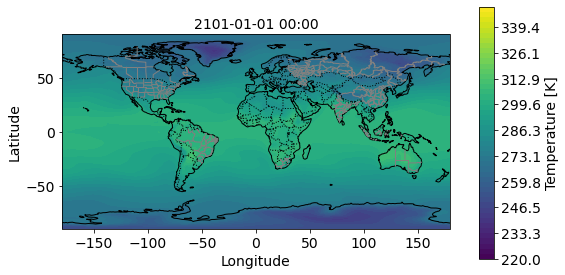

In [49]:
%matplotlib inline
fig = plt.figure(figsize=(8,5))
ax = plt.axes(projection=ccrs.PlateCarree())

## Set up colorbar values
ticks = np.linspace(220,350,50)

lon = ds_T['lon']
lat = ds_T['lat']

# Filled-contour plots
im1 = ax.contourf(lon, lat,  np.array(ds_T['T'][-1,-1,:,:]), ticks)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.025, 0.7])
                                                                 
cbar = fig.colorbar(im1, cax=cbar_ax)
cbar.set_label('Temperature [K]', fontsize=14)
cbar.ax.tick_params(labelsize=14)

ax.xaxis.set_visible(True)
ax.yaxis.set_visible(True)
ax.tick_params(labelsize=14)
ax.set_xlabel("Longitude", fontsize=14)
ax.set_ylabel("Latitude", fontsize=14)
ax.set_title((ds_T['time'].values[-1]).strftime('%Y-%m-%d %H:%M'), fontsize=14)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.OCEAN)
# Create a feature for States/Admin 1 regions at 1:50m from Natural Earth
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(states_provinces, edgecolor='gray')
plt.show()

## Now do the same thing for the **historical** runs.

In [51]:
# Define directories to read in and open as xarray

# Temperature
filenames_T_hist = sorted([f for f in glob.glob("orig_CESM-LENS2/*HIST*.h0.T.*")])
# Surface temperature
filenames_TSA_hist = sorted([f for f in glob.glob("orig_CESM-LENS2/*HIST*.h0.TSA.*")])

#open with xarray
ds_T_hist = xr.open_mfdataset(filenames_T_hist, concat_dim = 'time', combine = 'nested', parallel=True)
ds_TSA_hist = xr.open_mfdataset(filenames_TSA_hist, concat_dim = 'time', combine = 'nested', parallel=True)

In [52]:
# Get future data for only the time we are interested in: January 2081 to December 2100
ds_T_mon_avg_hist = ds_T_hist.where(ds_T_hist['time.year'] >= 1991, drop = True)
ds_T_mon_avg_hist = ds_T_mon_avg_hist.where(ds_T_mon_avg_hist['time.year'] < 2011, drop = True)
ds_T_Jan_avg_hist = ds_T_mon_avg_hist.where(ds_T_mon_avg_hist['time.month'] == 1, drop = True).mean('time')

ds_TSA_mon_avg_hist = ds_TSA_hist.where(ds_TSA_hist['time.year'] >= 1991, drop = True)
ds_TSA_mon_avg_hist = ds_TSA_mon_avg_hist.where(ds_TSA_mon_avg_hist['time.year'] < 2011, drop = True)
ds_TSA_Jan_avg_hist = ds_TSA_mon_avg_hist.where(ds_TSA_mon_avg_hist['time.month'] == 1, drop = True).mean('time')

## Subtract historical from future to calculate CESM2-LE anomalies.

In [8]:
#Have to subtract the entire xarrays for it to work (I checked on lev 0)
T_anom_xr = ds_T_Jan_avg_future['T'] - ds_T_Jan_avg_hist['T']
TSA_anom_xr = ds_TSA_Jan_avg_future['TSA'] - ds_TSA_Jan_avg_hist['TSA']

##A note for when calculating wind speed that will be added to the NARR files:
# WS_future = (ds_U_Jan_avg_future['U']**2 + ds_V_Jan_avg_future['V']**2)**0.5
# WS_hist = (ds_U_Jan_avg_hist['U']**2 + ds_V_Jan_avg_hist['V']**2)**0.5
# WS_anom = WS_future - WS_hist

# **Step 2**: Horizontal Interpolation - Put CESM Anomalies on the NARR projection (via ArcMap)

In [ ]:
## Output xarray anomalies to NetCDF files to be read in GIS
T_anom_xr.to_netcdf('T_anom_CESM2LENS_toGIS.nc', mode='w')
TSA_anom_xr.to_netcdf('TSA_anom_CESM2LENS_toGIS.nc', mode='w')

Use GIS model that I developed to horizontally interpolate the CESM anomalies to the NARR grid.

In [53]:
## Read in the output from GIS with horizontally interpolated anomalies
T_anom_onNARR = xr.open_dataset('TonNARRhoriz.nc')
TSA_anom_onNARR = xr.open_dataset('TSAonNARRhoriz.nc')

**Important things to note for this output from GIS:**
- **The 0th index values for both lat and lon are null values, so use [level, 1:,1:] for indexing data**
- **The 32nd Band is the surface!!**

So how does it look? Let's plot it:

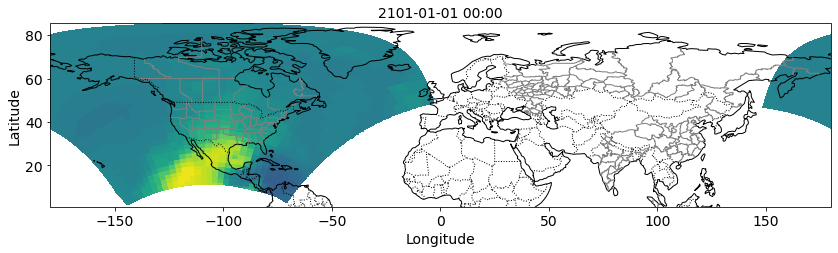

In [54]:
%matplotlib inline
fig = plt.figure(figsize=(14,12))
ax = plt.axes(projection=ccrs.PlateCarree())

## Set up colorbar values
ticks = np.linspace(-10,20,50)

lon = NARR_ds['longitude']
lat = NARR_ds['latitude']

# Filled-contour plots
im1 = ax.contourf(lon, lat,  np.array(T_anom_onNARR['Extracted_CESM'][-1,1:,1:]), ticks)

ax.xaxis.set_visible(True)
ax.yaxis.set_visible(True)
ax.tick_params(labelsize=14)
ax.set_xlabel("Longitude", fontsize=14)
ax.set_ylabel("Latitude", fontsize=14)
ax.set_title((ds_T['time'].values[-1]).strftime('%Y-%m-%d %H:%M'), fontsize=14)

ax.add_feature(cfeature.COASTLINE)
# Create a feature for States/Admin 1 regions at 1:50m from Natural Earth
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(states_provinces, edgecolor='gray')

plt.show()

# **Step 3**: Vertical Interpolation

Match the 32 CESM2-LE vertical bands to the NARR vertical levels.

Use: **wrf.interplevel(field3d, vert, desiredlev, missing=\<MagicMock name='mock().item()' id='140675643013392'>, squeeze=True, meta=True)**

More info here: https://wrf-python.readthedocs.io/en/latest/user_api/generated/wrf.interplevel.html

In [34]:
# Remember how the 32nd band from GIS is the surface? Let's fix that...
# the _tp stands for transpose
T_anom_onNARR_tp = T_anom_onNARR.reindex(y=list(reversed(T_anom_onNARR.y)))
#no need for TSA because at the surface but we will do it anyway to be consistent with labeling
TSA_anom_onNARR_tp = TSA_anom_onNARR.reindex(y=list(reversed(TSA_anom_onNARR.y)))

# Now remove nan values and replace with zeros (this is important for the upcoming vertical interpolation)
# If there is no value, then just add zero for the anomaly (does not impact results)
T_anom_onNARR_tp['Extracted_CESM'] = T_anom_onNARR_tp['Extracted_CESM'].fillna(0)
TSA_anom_onNARR_tp['Extracted_CESM'] =TSA_anom_onNARR_tp['Extracted_CESM'].fillna(0)

In [43]:
# Make an 3D xarray filled with pressure values for CESM_levs:
CESM_orig_T = xr.open_dataset('orig_CESM-LENS2/b.e21.BHISTcmip6.f09_g17.LE2-1001.001.cam.h0.T.199001-199912.nc')
CESM_levs = CESM_orig_T['lev']

CESM_levs_3d = xr.open_dataset('CESM_levs_3d.nc') #open this GIS output

In [44]:
desiredNARR_levs = [1000, 975, 950, 925, 900, 875, 850, 825, 800, 775, 750, 725, 700, 650, 600, 550, 500,
           450, 400, 350, 300, 275, 250, 225, 200, 175, 150, 125, 100]

T_anom_onNARR_tp = T_anom_onNARR_tp.assign_coords(band=CESM_levs)
T_anom_onNARR_tp_interp = wrf.interplevel(T_anom_onNARR_tp['Extracted_CESM'], CESM_levs_3d['Extracted_CESM'], desiredNARR_levs) #add the actual CESM levels to the xarray

#No PSL, TSA, or PS because only surface level!

One *complication*: cannot interpolate down to 1000 hPa because CESM-LENS2 only goes to 992 hPa.
Must use a "nearest neighbor" approach and set the 1000 hPa values to the 992 hPa values. Since pressure is an exponential function, this assumption should be okay.

In [45]:
T_anom_onNARR_tp_interp[0] = T_anom_onNARR['Extracted_CESM'][-1].reindex(y=list(reversed(T_anom_onNARR.y))).fillna(0)

#No PSL, TSA, or PS because only surface level!

# **Step 4**: Add CESM2-LE anomalies to the NARR data for the respective variable

In [ ]:
#function for levels
def get_NARR_lev_idx(level, filetype):
    PBL_levs = [30, 60, 90, 120, 150, 180]
    levs_3D = [1000, 975, 950, 925, 900, 875, 850, 825, 800, 775, 750, 725, 700, 650, 600, 550, 500,
           450, 400, 350, 300, 275, 250, 225, 200, 175, 150, 125, 100]
    counter = 0
    if filetype == 'PBL':
        for lev in PBL_levs:
            if level == lev:
                return counter #this will be the index to use
            counter+=1
    if filetype == '3D':
        for lev in levs_3D:
            if level == lev:
                return counter #this will be the index to use
            counter+=1

In [ ]:
def change_grib(dataIN, filetype):#, dataEDGE):
    #Function to change the grib data and smooth edges
    #based on file type
    
    
    if filetype == 'SFC': #surface file, so only change 2m temperature and 
        if dataIN.marsParam == '11.131': #temperature
            # print('Sfc Temp', dataIN.level)
            newdata = dataIN.values + TSA_anom_onNARR_tp['Extracted_CESM'][0,1:,1:] #add the anomalies
            
        elif dataIN.marsParam == '1.131': #sfc pressure
            # print('Sfc Pressure', dataIN.level)
            newdata = dataIN.values + PS_anom_onNARR_tp['Extracted_CESM'][0,1:,1:] #add the anomalies
        
        else: #something we do not want to change
            # print('NOT CHANGING: ',dataIN)
            newdata = dataIN.values
            
            
    elif filetype == 'FLX': #what level would this be? should only be 2m above
        if dataIN.marsParam == '11.131' and dataIN.level == 2: #2m temperature
            # print('2m Temp', dataIN.level)
            newdata = dataIN.values + TSA_anom_onNARR_tp['Extracted_CESM'][0,1:,1:] #add the anomalies, not _interp because only surface level
        
        elif dataIN.marsParam == '2.131' and dataIN.level == 0: #Pressure reduced to mean sea level (PRMSL - NARR)
            # print('Pres. red. to MSL', dataIN.level)
            newdata = dataIN.values + PSL_anom_onNARR_tp['Extracted_CESM'][0,1:,1:] #add the anomalies, not _interp because only surface level
        
        else: #something we do not want to change
            # print('NOT CHANGING: ',dataIN)
            newdata = dataIN.values
            
            
    elif filetype == '3D':
        if dataIN.marsParam == '11.131': #temperature
            # print('Temp', dataIN.level)
            lev = get_NARR_lev_idx(dataIN.level, filetype)
            newdata = dataIN.values + T_anom_onNARR_tp_interp[lev,1:,1:] #add the anomalies

        elif dataIN.marsParam == '51.131': #SPFH - Q
            # print('Spec. Hum.', dataIN.level)
            lev = get_NARR_lev_idx(dataIN.level, filetype)
            newdata = dataIN.values + Q_anom_onNARR_tp_interp[lev,1:,1:] #add the anomalies

        elif dataIN.marsParam == '33.131': #U
            # print('U', dataIN.level)
            lev = get_NARR_lev_idx(dataIN.level, filetype)
            newdata = dataIN.values + U_anom_onNARR_tp_interp[lev,1:,1:] #add the anomalies

        elif dataIN.marsParam == '34.131': #V
            # print('V', dataIN.level)
            lev = get_NARR_lev_idx(dataIN.level, filetype)
            newdata = dataIN.values + V_anom_onNARR_tp_interp[lev,1:,1:] #add the anomalies

        elif dataIN.marsParam == '39.131': #VVEL - W
            # print('VVEL', dataIN.level)  
            lev = get_NARR_lev_idx(dataIN.level, filetype)
            newdata = dataIN.values + OMEGA_anom_onNARR_tp_interp[lev,1:,1:] #add the anomalies
        
        elif dataIN.marsParam == '7.131': #geopot hgt
            # print('Geopot hght', dataIN.level)  
            lev = get_NARR_lev_idx(dataIN.level, filetype)
            newdata = dataIN.values + geopot_hgt_anom_onNARR_tp_interp[lev,1:,1:] #add the anomalies

        else: #something we do not want to change
            # print('NOT CHANGING: ',dataIN)
            newdata = dataIN.values

    # newdata = np.where(dataEDGE>0, gfilt(newdata*1.0, sigma=1.5), newdata)
    newdata = np.ma.masked_where(dataIN == 9999., newdata)
    newdata = np.ma.masked_where(dataIN == 'nan', newdata)
    return newdata

In [ ]:
#strings for opening files to be worked on (NARR)
all_dates_modifying_3D = pd.date_range('1982-01-13 00:00:00', '1982-01-21 21:00:00', freq='3H').strftime('%Y%m%d%H')[:]
all_dates_modifying_SFC = pd.date_range('1982-01-10 00:00:00', '1982-01-19 21:00:00', freq='3H').strftime('%Y%m%d%H')[:]
all_dates_modifying_FLX = pd.date_range('1982-01-09 00:00:00', '1982-01-24 21:00:00', freq='3H').strftime('%Y%m%d%H')[:]
#.clm starts at 1982-01-02-00, nothing in here that we edit

3D files:

In [ ]:
for numer_, date_ in enumerate(all_dates_modifying_3D):
    #file to be worked on
    fileIN = 'merged_AWIP32.'+date_+'.3D'
    
    fileOUT = open('edited_NARR/' + fileIN[:-3]+'_CESMLENS2_Anom_'+fileIN[-3:], 'ab')

    grbsIN = pygrib.open('orig_NARR/'+fileIN)
    
    for checker, dataIN in enumerate(grbsIN):
        newdata = change_grib(dataIN, '3D')
        dataIN.values = newdata
        msg = dataIN.tostring()
        fileOUT.write(msg)

SFC files:

In [ ]:
for numer_, date_ in enumerate(all_dates_modifying_SFC):
    #file to be worked on
    fileIN = 'merged_AWIP32.'+date_+'.RS.sfc'
    
    fileOUT = open('edited_NARR/' + fileIN[:-4]+'_CESMLENS2_Anom_'+fileIN[-4:], 'ab')

    grbsIN = pygrib.open('orig_NARR/'+fileIN)
    
    for checker, dataIN in enumerate(grbsIN):
        newdata = change_grib(dataIN, 'SFC')
        dataIN.values = newdata
        msg = dataIN.tostring()
        fileOUT.write(msg)

FLX files:

In [ ]:
for numer_, date_ in enumerate(all_dates_modifying_FLX):
    #file to be worked on
    fileIN = 'merged_AWIP32.'+date_+'.RS.flx'
    
    fileOUT = open('edited_NARR/' + fileIN[:-4]+'_CESMLENS2_Anom_'+fileIN[-4:], 'ab')

    grbsIN = pygrib.open('orig_NARR/'+fileIN)
    
    for checker, dataIN in enumerate(grbsIN):
        newdata = change_grib(dataIN, 'FLX')
        dataIN.values = newdata
        msg = dataIN.tostring()
        fileOUT.write(msg)

## Use this to check that the files have been edited:

In [ ]:
check = pygrib.open('orig_NARR/merged_AWIP32.1982011300.3D')
check2 = pygrib.open('edited_NARR/merged_AWIP32.1982011300_CESMLENS2_Anom_.3D')
idx = 1
for g in check2:
    if idx == 2:
        print(g.values, g)
    idx+=1